# Setup

In [32]:
import pandas as pd
import numpy as np
import pickle
import networkx as nx
from sklearn.preprocessing import MinMaxScaler
from pylab import rcParams

In [33]:
users_df = pd.read_csv(r'./Scraping/data/uber_users.csv') # Per user data
uber_df = pd.read_pickle(r'./data/uber_tk.p')

# Delete index column
users_df.drop(users_df.columns[0], axis=1, inplace=True)

In [34]:
users_df.head()

,user,listed,followers
0,Michael05914091,0,8
1,ShieldVoC,18,17566
2,fltrtae,15,1717
3,Lucky00890359,0,0
4,zhenyalindgardt,1,55


In [35]:
uber_df.head()

,source,source_id,target,target_id,type_of_content,created_at,all_data,text
0,Uber_Support,2815754953,wordofbrandon,2566081240,Reply,2019-08-31 10:53:53,{'created_at': 'Sat Aug 31 10:53:53 +0000 2019...,"[wordofbrandon, thanks, bringing, attention, w..."
1,Uber_Support,2815754953,wordofbrandon,2566081240,Reply,2019-08-31 10:53:53,{'created_at': 'Sat Aug 31 10:53:53 +0000 2019...,"[wordofbrandon, thanks, bringing, attention, w..."
2,Uber_Support,2815754953,CapeVgirl,719534538,Reply,2019-10-01 07:45:30,{'created_at': 'Tue Oct 01 07:45:30 +0000 2019...,"[capevgirl, help, suggest, restarting, app, wo..."
3,Uber_Support,2815754953,CapeVgirl,719534538,Reply,2019-10-01 07:45:30,{'created_at': 'Tue Oct 01 07:45:30 +0000 2019...,"[capevgirl, help, suggest, restarting, app, wo..."
4,SatishInnov8,722043526461145088,Uber_Support,2815754953,Reply,2019-12-09 17:11:51,{'created_at': 'Mon Dec 09 17:11:51 +0000 2019...,"[ubersupport, wish, respectfully, state, regul..."


In [36]:
uber_df['all_data'][0]

{'created_at': 'Sat Aug 31 10:53:53 +0000 2019',
 'id': 1167752362733293568,
 'id_str': '1167752362733293568',
 'text': '@wordofbrandon Thanks for bringing this to our attention, @wordofbrandon. Our team is currently reviewing and will… https://t.co/9laWax1Uoh',
 'truncated': True,
 'entities': {'hashtags': [],
  'symbols': [],
  'user_mentions': [{'screen_name': 'wordofbrandon',
    'name': 'Brandon Jones',
    'id': 2566081240,
    'id_str': '2566081240',
    'indices': [0, 14]},
   {'screen_name': 'wordofbrandon',
    'name': 'Brandon Jones',
    'id': 2566081240,
    'id_str': '2566081240',
    'indices': [58, 72]}],
  'urls': [{'url': 'https://t.co/9laWax1Uoh',
    'expanded_url': 'https://twitter.com/i/web/status/1167752362733293568',
    'display_url': 'twitter.com/i/web/status/1…',
    'indices': [116, 139]}]},
 'source': '<a href="https://www.sprinklr.com" rel="nofollow">Sprinklr</a>',
 'in_reply_to_status_id': 1167748661633142784,
 'in_reply_to_status_id_str': '11677486616331

In [37]:
uber_df['type_of_content'].value_counts()

Reply      5253
Mention     254
Tweet        61
Name: type_of_content, dtype: int64

In [39]:
# Calculate types per user
users_df['reply_sent'] = pd.to_numeric(uber_df[uber_df['type_of_content'] == 'Reply'].groupby('source')['type_of_content'].transform('count'))
users_df['reply_recieved'] = pd.to_numeric(uber_df[uber_df['type_of_content'] == 'Reply'].groupby('target')['type_of_content'].transform('count'))
users_df['mention_sent'] = pd.to_numeric(uber_df[uber_df['type_of_content'] == 'Mention'].groupby('source')['type_of_content'].transform('count'))
users_df['mention_recieved'] = pd.to_numeric(uber_df[uber_df['type_of_content'] == 'Mention'].groupby('target')['type_of_content'].transform('count'))
users_df['tweet_sent'] = pd.to_numeric(uber_df[uber_df['type_of_content'] == 'Tweet'].groupby('source')['type_of_content'].transform('count'))
users_df['tweet_recieved'] = pd.to_numeric(uber_df[uber_df['type_of_content'] == 'Tweet'].groupby('target')['type_of_content'].transform('count'))

In [40]:
users_df.describe()

,listed,followers,reply_sent,reply_recieved,mention_sent,mention_recieved,tweet_sent,tweet_recieved
count,2578.000000,2.578000e+03,2502.000000,2502.000000,63.000000,63.000000,13.000000,13.000000
mean,133.553142,5.738144e+04,262.248601,1992.258993,4.714286,72.190476,2.000000,2.000000
std,3042.780387,1.213325e+06,480.116203,1489.011667,4.598136,42.185786,1.414214,1.414214
min,0.000000,0.000000e+00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,0.000000,3.000000e+00,1.000000,5.250000,1.000000,22.000000,1.000000,1.000000
50%,0.000000,3.500000e+01,2.000000,3126.000000,3.000000,65.000000,1.000000,1.000000
75%,3.000000,2.492500e+02,9.000000,3126.000000,8.000000,115.000000,4.000000,4.000000
max,147751.000000,5.338561e+07,1149.000000,3126.000000,13.000000,115.000000,4.000000,4.000000


# User Network

In [41]:
users_df.fillna(0, inplace=True) # Consitency
users_df

,user,listed,followers,reply_sent,reply_recieved,mention_sent,mention_recieved,tweet_sent,tweet_recieved
0,Michael05914091,0,8,1149.0,3.0,0.0,0.0,0.0,0.0
1,ShieldVoC,18,17566,1149.0,3.0,0.0,0.0,0.0,0.0
2,fltrtae,15,1717,1149.0,4.0,0.0,0.0,0.0,0.0
3,Lucky00890359,0,0,1149.0,4.0,0.0,0.0,0.0,0.0
4,zhenyalindgardt,1,55,3.0,3126.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
2573,fayedicksonxo,0,213,1.0,3126.0,0.0,0.0,0.0,0.0
2574,Iam_bahuguna,0,90,1.0,3126.0,0.0,0.0,0.0,0.0
2575,ajb_neuk,0,3,0.0,0.0,8.0,115.0,0.0,0.0
2576,k_sovs,0,2,0.0,0.0,8.0,2.0,0.0,0.0


In [42]:
# Create network
G = nx.DiGraph()

edges = list()
for (a,b) in zip(uber_df['source'], uber_df['target']):
    edges.append((a,b))

G.add_edges_from(edges)
G

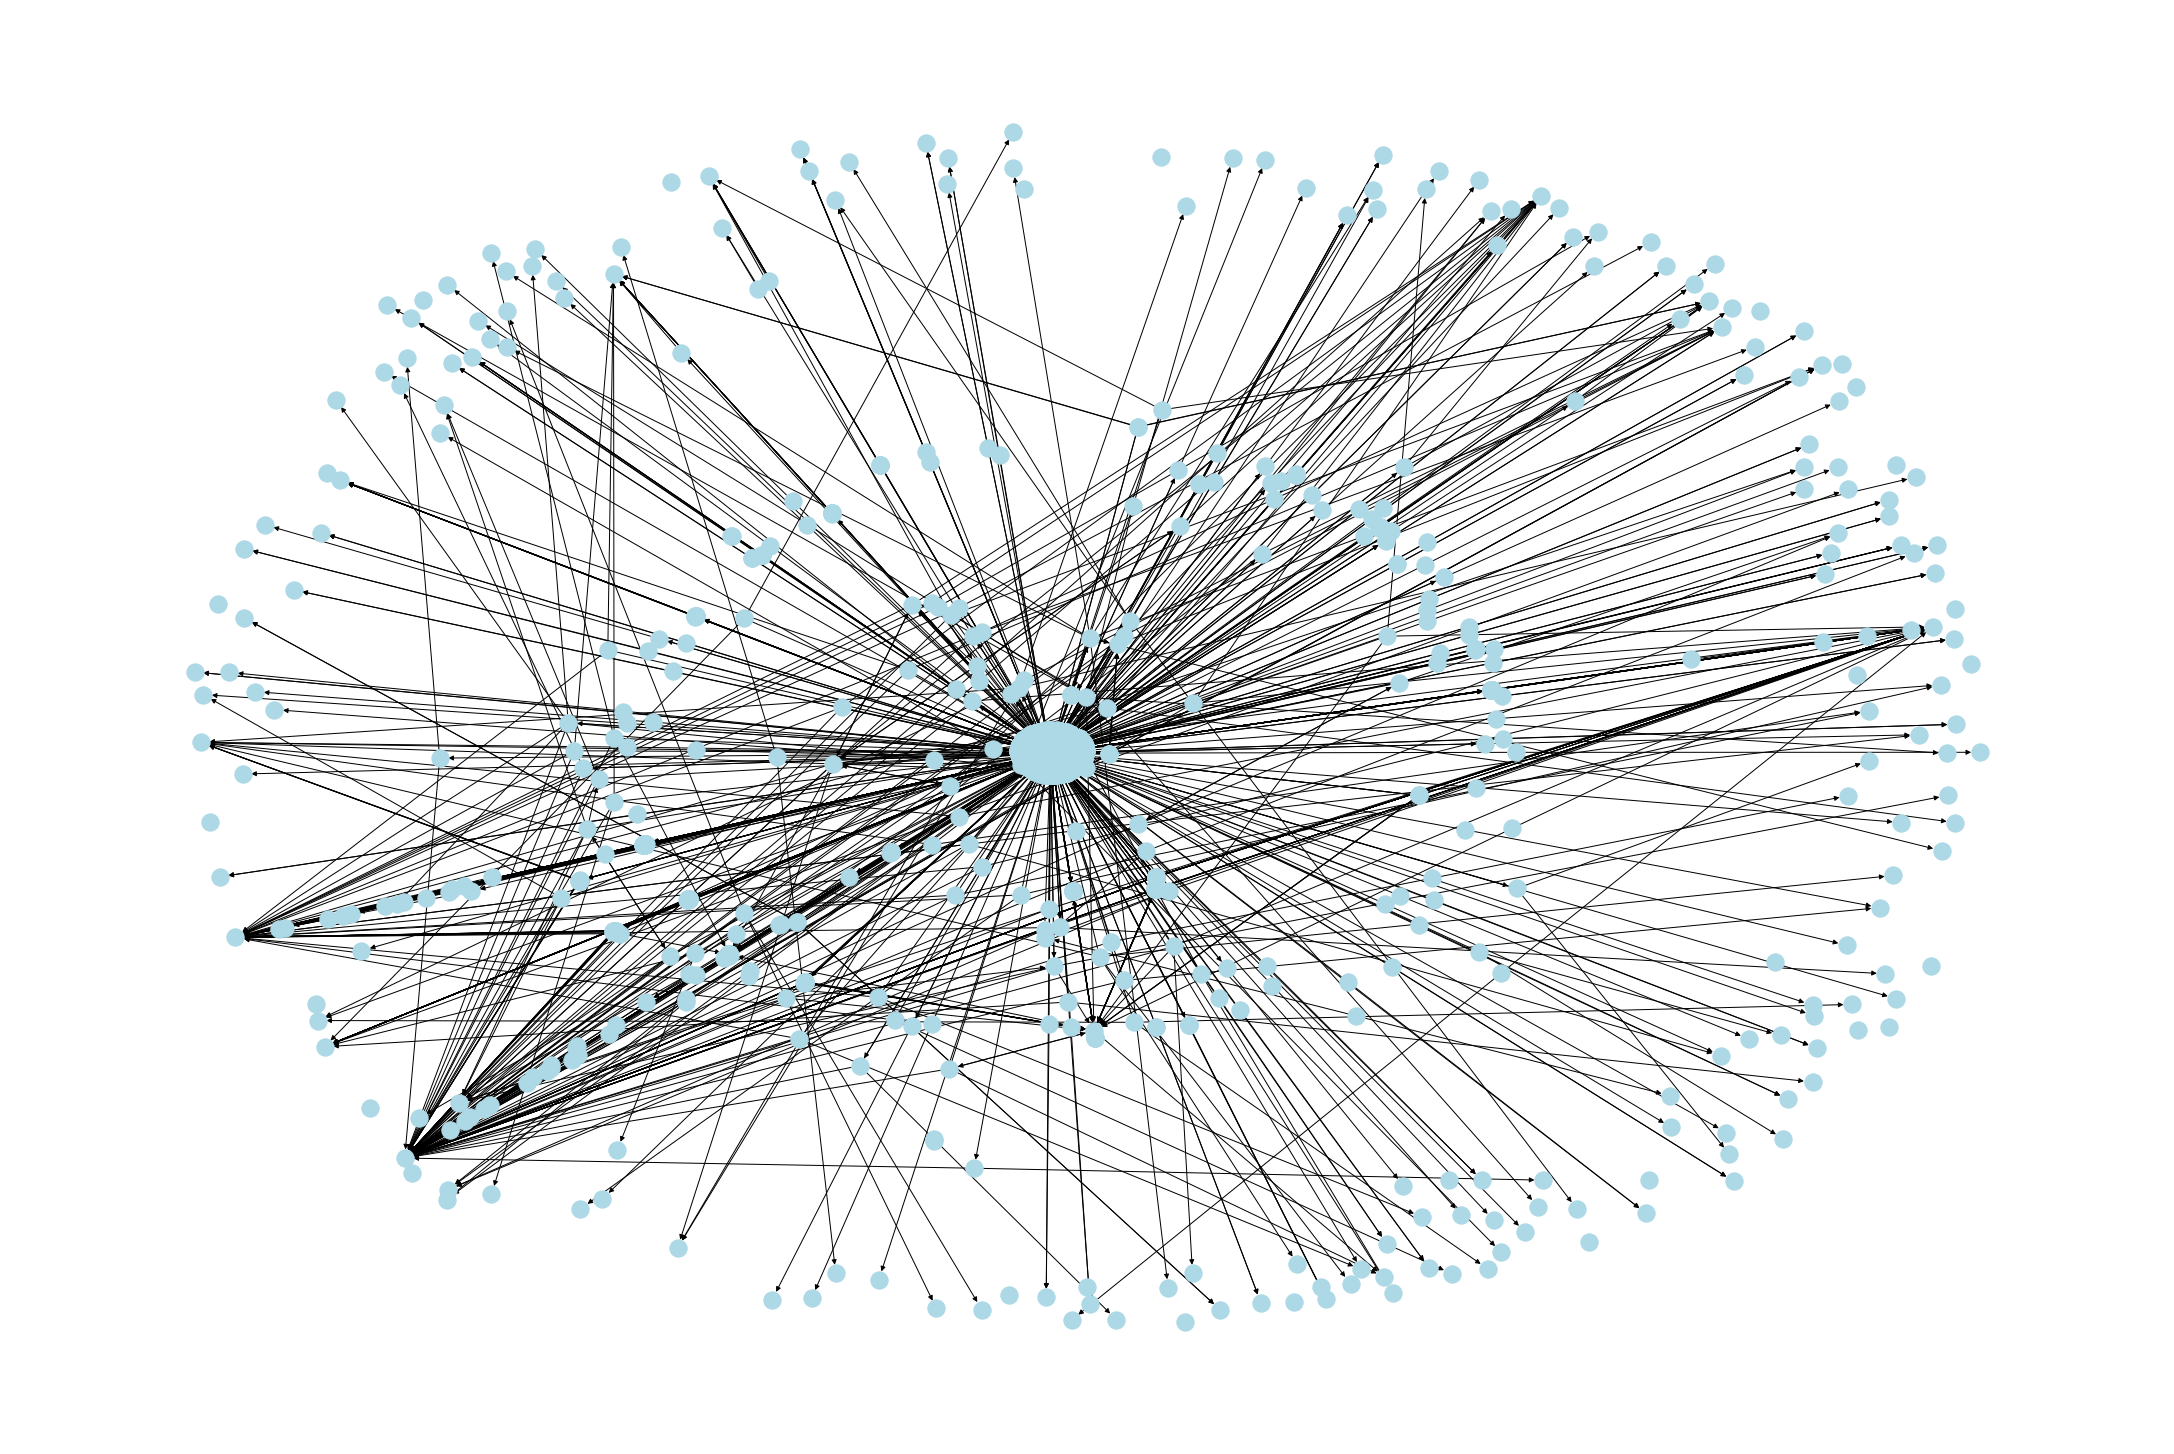

In [43]:
rcParams['figure.figsize'] = 30, 20
pos = nx.spring_layout(G, scale=0.15, k=0.5/np.sqrt(G.order()))
nx.draw(G, pos, node_color='lightblue')

In [44]:
degree_centrality=pd.DataFrame.from_dict(nx.degree_centrality(G), orient='index').reset_index()
degree_centrality

,index,0
0,Uber_Support,1.215641
1,wordofbrandon,0.000774
2,CapeVgirl,0.000774
3,SatishInnov8,0.000774
4,realchetty,0.000774
...,...,...
2579,Nezz911,0.001161
2580,NeoVonAxiom,0.000387
2581,ajb_neuk,0.000774
2582,Iam_bahuguna,0.000387


In [45]:
closeness_centrality=pd.DataFrame.from_dict(nx.closeness_centrality(G), orient='index').reset_index()
closeness_centrality

,index,0
0,Uber_Support,0.897051
1,wordofbrandon,0.450255
2,CapeVgirl,0.450255
3,SatishInnov8,0.000000
4,realchetty,0.449965
...,...,...
2579,Nezz911,0.449965
2580,NeoVonAxiom,0.000000
2581,ajb_neuk,0.449965
2582,Iam_bahuguna,0.000000


In [46]:
betweenness_centrality=pd.DataFrame.from_dict(nx.betweenness_centrality(G), orient='index').reset_index()
betweenness_centrality

,index,0
0,Uber_Support,0.304169
1,wordofbrandon,0.000000
2,CapeVgirl,0.000000
3,SatishInnov8,0.000000
4,realchetty,0.000000
...,...,...
2579,Nezz911,0.000012
2580,NeoVonAxiom,0.000000
2581,ajb_neuk,0.000000
2582,Iam_bahuguna,0.000000


In [47]:
network_measures = degree_centrality.merge(closeness_centrality, on='index').merge(betweenness_centrality, on='index')
network_measures

,index,0_x,0_y,0
0,Uber_Support,1.215641,0.897051,0.304169
1,wordofbrandon,0.000774,0.450255,0.000000
2,CapeVgirl,0.000774,0.450255,0.000000
3,SatishInnov8,0.000774,0.000000,0.000000
4,realchetty,0.000774,0.449965,0.000000
...,...,...,...,...
2579,Nezz911,0.001161,0.449965,0.000012
2580,NeoVonAxiom,0.000387,0.000000,0.000000
2581,ajb_neuk,0.000774,0.449965,0.000000
2582,Iam_bahuguna,0.000387,0.000000,0.000000


In [48]:
network_measures.columns = ['user', 'degree', 'closeness', 'betweenness'] # Consistent formatting

In [49]:
network_measures = network_measures.merge(users_df, on='user') # Merge on unique user name
network_measures

,user,degree,closeness,betweenness,listed,followers,reply_sent,reply_recieved,mention_sent,mention_recieved,tweet_sent,tweet_recieved
0,Uber_Support,1.215641,0.897051,0.304169,523,591423,1.0,3126.0,0.0,0.0,0.0,0.0
1,wordofbrandon,0.000774,0.450255,0.000000,56,24501,1.0,3126.0,0.0,0.0,0.0,0.0
2,CapeVgirl,0.000774,0.450255,0.000000,9,133,1.0,3126.0,0.0,0.0,0.0,0.0
3,SatishInnov8,0.000774,0.000000,0.000000,1,441,1.0,3126.0,0.0,0.0,0.0,0.0
4,realchetty,0.000774,0.449965,0.000000,1,138,1149.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2573,Nezz911,0.001161,0.449965,0.000012,4,658,2.0,119.0,0.0,0.0,0.0,0.0
2574,NeoVonAxiom,0.000387,0.000000,0.000000,0,4,13.0,3126.0,0.0,0.0,0.0,0.0
2575,ajb_neuk,0.000774,0.449965,0.000000,0,3,0.0,0.0,8.0,115.0,0.0,0.0
2576,Iam_bahuguna,0.000387,0.000000,0.000000,0,90,1.0,3126.0,0.0,0.0,0.0,0.0


In [50]:
network_measures.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2578 entries, 0 to 2577
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   user              2578 non-null   object 
 1   degree            2578 non-null   float64
 2   closeness         2578 non-null   float64
 3   betweenness       2578 non-null   float64
 4   listed            2578 non-null   int64  
 5   followers         2578 non-null   int64  
 6   reply_sent        2578 non-null   float64
 7   reply_recieved    2578 non-null   float64
 8   mention_sent      2578 non-null   float64
 9   mention_recieved  2578 non-null   float64
 10  tweet_sent        2578 non-null   float64
 11  tweet_recieved    2578 non-null   float64
dtypes: float64(9), int64(2), object(1)
memory usage: 261.8+ KB


In [51]:
network_measures.set_index('user', inplace=True)

In [52]:
# Normalize
scaled_features = MinMaxScaler().fit_transform(network_measures.values)

In [53]:
normalized_network_measures = pd.DataFrame(scaled_features, index=network_measures.index, columns=network_measures.columns)
normalized_network_measures

,degree,closeness,betweenness,listed,followers,reply_sent,reply_recieved,mention_sent,mention_recieved,tweet_sent,tweet_recieved
user,,,,,,,,,,,
Uber_Support,1.000000,1.000000,1.000000,0.003540,1.107832e-02,0.000870,1.000000,0.000000,0.0,0.0,0.0
wordofbrandon,0.000319,0.501927,0.000000,0.000379,4.589439e-04,0.000870,1.000000,0.000000,0.0,0.0,0.0
CapeVgirl,0.000319,0.501927,0.000000,0.000061,2.491308e-06,0.000870,1.000000,0.000000,0.0,0.0,0.0
SatishInnov8,0.000319,0.000000,0.000000,0.000007,8.260653e-06,0.000870,1.000000,0.000000,0.0,0.0,0.0
realchetty,0.000319,0.501604,0.000000,0.000007,2.584966e-06,1.000000,0.000320,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
Nezz911,0.000637,0.501604,0.000039,0.000027,1.232542e-05,0.001741,0.038068,0.000000,0.0,0.0,0.0
NeoVonAxiom,0.000000,0.000000,0.000000,0.000000,7.492656e-08,0.011314,1.000000,0.000000,0.0,0.0,0.0
ajb_neuk,0.000319,0.501604,0.000000,0.000000,5.619492e-08,0.000000,0.000000,0.615385,1.0,0.0,0.0


In [54]:
normalized_network_measures['score'] = normalized_network_measures[:].sum(axis=1)
normalized_network_measures['score']

user
Uber_Support     4.015488
wordofbrandon    1.503954
CapeVgirl        1.503180
SatishInnov8     1.001204
realchetty       1.502252
                   ...   
Nezz911          0.542129
NeoVonAxiom      1.011314
ajb_neuk         2.117308
Iam_bahuguna     1.000872
MY0U1SANA        1.001412
Name: score, Length: 2578, dtype: float64

In [55]:
# Top 200
results = normalized_network_measures.nlargest(200, 'score', keep='all')
results

,degree,closeness,betweenness,listed,followers,reply_sent,reply_recieved,mention_sent,mention_recieved,tweet_sent,tweet_recieved,score
user,,,,,,,,,,,,
Uber_Support,1.000000,1.000000,1.0,0.003540,1.107832e-02,0.000870,1.000000,0.000000,0.0,0.0,0.0,4.015488
1975aregr8t,0.000319,0.501604,0.0,0.000000,6.930707e-07,0.000000,0.000000,0.000000,0.0,1.0,1.0,2.501924
MrsKiraly,0.000319,0.501604,0.0,0.000000,1.311215e-07,0.000000,0.000000,0.000000,0.0,1.0,1.0,2.501923
ajb_neuk,0.000319,0.501604,0.0,0.000000,5.619492e-08,0.000000,0.000000,0.615385,1.0,0.0,0.0,2.117308
CNN,0.000000,0.000432,0.0,1.000000,1.000000e+00,0.002611,0.079655,0.000000,0.0,0.0,0.0,2.082697
...,...,...,...,...,...,...,...,...,...,...,...,...
ariojosdemiel,0.000319,0.501604,0.0,0.000000,1.142630e-06,1.000000,0.001919,0.000000,0.0,0.0,0.0,1.503843
AcreUK,0.000319,0.501604,0.0,0.000129,4.126580e-05,0.001741,1.000000,0.000000,0.0,0.0,0.0,1.503833
divyanshu_nd,0.000956,0.501927,0.0,0.000054,1.869418e-05,0.000870,1.000000,0.000000,0.0,0.0,0.0,1.503826


In [56]:
results.to_csv(r'.\data\aggregated_uber_results.csv')